In [1]:
import matplotlib.pyplot as plt  # 图形库
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score  # 导入轮廓系数指标
from sklearn.cluster import KMeans  # KMeans模块
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder  # 数据预处理库
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib
# 解决中文乱码
plt.rcParams['font.sans-serif']=['simHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df = pd.read_table('ad_performance.txt', delimiter='\t')#把数据读入程序
df.head()
#日均UV:日均独立用户数量

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
0,A203,3.69,0.0071,0.0214,2.3071,419.77,0.0258,20,jpg,banner,roi,140*40,打折
1,A387,178.70,0.0040,0.0324,2.0489,157.94,0.0030,19,jpg,banner,cpc,140*40,满减
2,A388,91.77,0.0022,0.0530,1.8771,357.93,0.0026,4,jpg,banner,cpc,140*40,满减
3,A389,1.09,0.0074,0.3382,4.2426,364.07,0.0153,10,jpg,banner,cpc,140*40,满减
4,A390,3.37,0.0028,0.1740,2.1934,313.34,0.0007,30,jpg,banner,cpc,140*40,满减


In [3]:
df.info()
# 由结果可知，总共有13个变量，1，2，3，4，5，6，7为连续型变量，其他为分类变量。

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   渠道代号    889 non-null    object 
 1   日均UV    889 non-null    float64
 2   平均注册率   889 non-null    float64
 3   平均搜索量   889 non-null    float64
 4   访问深度    889 non-null    float64
 5   平均停留时间  887 non-null    float64
 6   订单转化率   889 non-null    float64
 7   投放总时间   889 non-null    int64  
 8   素材类型    889 non-null    object 
 9   广告类型    889 non-null    object 
 10  合作方式    889 non-null    object 
 11  广告尺寸    889 non-null    object 
 12  广告卖点    889 non-null    object 
dtypes: float64(6), int64(1), object(6)
memory usage: 90.4+ KB


In [4]:
# 在 "平均停留时间"字段中有 2 个缺失值。由于缺失数量少且为连续型变量，可以使用均值法做填充。
# 注：如果为分类型变量，用众数填补可能更合适。
df = df.fillna(df['平均停留时间'].mean())

In [5]:
df.describe().round(3)
# 1. 日均 UV 的数据波动非常大，说明了不同渠道间的特征差异非常明显：由于广告的流量型特征明显，很多广告的流量爆发明显，因此渠道间确实有非常大的差异性，这些差异性应该保留，不能作为异常值处理。
# 2. 平均注册率、平均搜索量、订单转化率等多个统计量（例如最小值、 25%分位数等）都为 0，似乎数据不太正常，这些数值太小。

,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间
count,889.000,889.000,889.000,889.000,889.000,889.000,889.000
mean,540.847,0.001,0.030,2.167,262.669,0.003,16.053
std,1634.410,0.003,0.106,3.801,224.112,0.012,8.509
min,0.060,0.000,0.000,1.000,1.640,0.000,1.000
25%,6.180,0.000,0.001,1.392,126.200,0.000,9.000
50%,114.180,0.000,0.003,1.793,236.660,0.000,16.000
75%,466.870,0.001,0.012,2.216,357.930,0.002,24.000
max,25294.770,0.039,1.037,98.980,4450.830,0.216,30.000


<AxesSubplot:xlabel='平均注册率', ylabel='Density'>

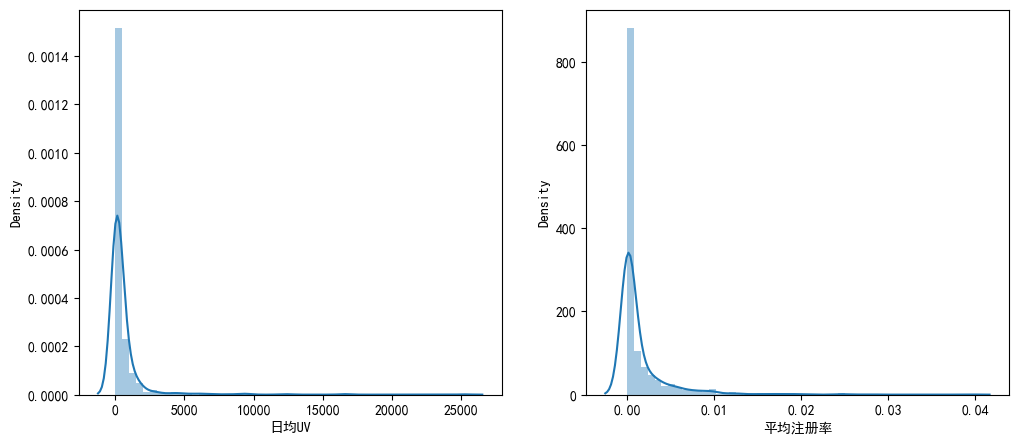

In [6]:
# 建模之前，我们还可以对数据做可视化分析，将繁杂的数据变得直观、清晰，更好地展示和解释数据。进行数据可视化时，变量类型至关重要。
# 连续变量可视化
# 以连续变量“日均UV”和“平均注册率”为例，画出它们的分布图。
# 创建包含两个子图的图形
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.distplot(df['日均UV'], ax=axes[0])
sns.distplot( df['平均注册率'], ax=axes[1])
# 日均UV和平均注册率都是右偏分布，有极端大值。

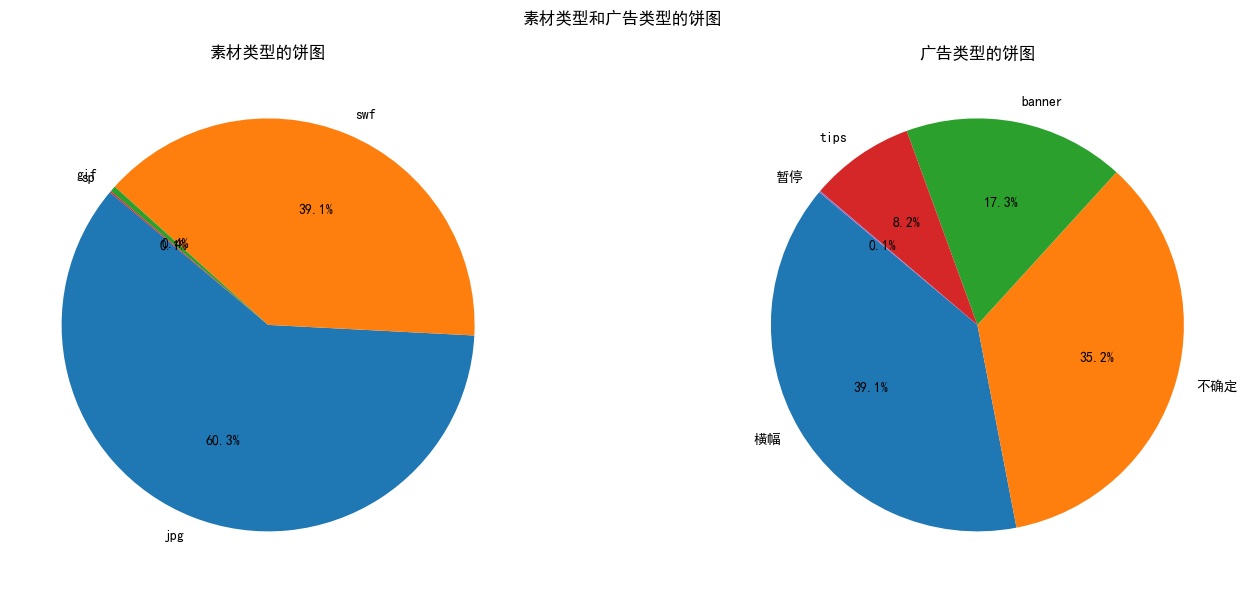

In [7]:
# 分类变量可视化
# 分类数据可以使用饼图、条形图、帕累托图等进行可视化展示。
# 这里我们以素材类型、广告类型画饼图，合作方式、广告尺寸画条形图为例展示，并尝试在一张大图中画入多个图形。
# 获取素材类型和广告类型的计数
material_counts = df['素材类型'].value_counts()
ad_type_counts = df['广告类型'].value_counts()
# 创建一个子图
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('素材类型和广告类型的饼图')
# 绘制素材类型的饼图
axes[0].pie(material_counts, labels=material_counts.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('素材类型的饼图')
# 绘制广告类型的饼图
axes[1].pie(ad_type_counts, labels=ad_type_counts.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('广告类型的饼图')
# 调整子图布局
plt.tight_layout()
# 显示图形
plt.show()
# 素材类型的饼图出现重合的部分，是因为gif和sp的数量都很少，jpg和swf的素材占绝大部分；在广告类型中，横幅最多，“不确定”其次。

In [8]:
#查看分类具体数值
print("material_counts:\n",material_counts)
print("ad_type_counts:\n",ad_type_counts)

material_counts:
 jpg    536
swf    348
gif      4
sp       1
Name: 素材类型, dtype: int64
ad_type_counts:
 横幅        348
不确定       313
banner    154
tips       73
暂停          1
Name: 广告类型, dtype: int64


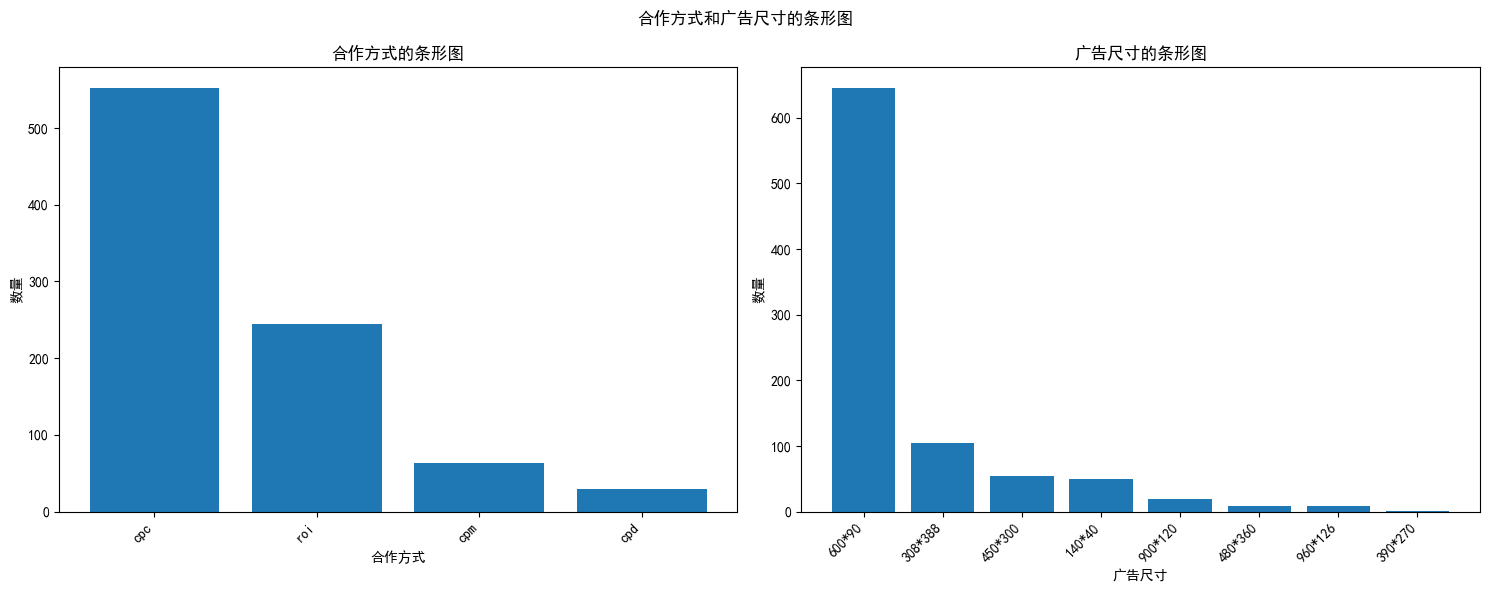

In [9]:
#绘制合作方式和广告尺寸柱状图
# 获取合作方式和广告尺寸的计数
cooperation_counts = df['合作方式'].value_counts()
ad_size_counts = df['广告尺寸'].value_counts()
# 创建一个子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('合作方式和广告尺寸的条形图')
# 绘制合作方式的条形图
ax1.bar(cooperation_counts.index, cooperation_counts.values)
ax1.set_xlabel('合作方式')
ax1.set_ylabel('数量')
ax1.set_title('合作方式的条形图')
ax1.set_xticks(cooperation_counts.index)  # 设置 x 轴刻度
ax1.set_xticklabels(cooperation_counts.index, rotation=45, ha='right')  # 设置 x 轴标签
# for i, value in enumerate(cooperation_counts):
#     ax1.text(i, value + 5, str(value), ha='center', va='bottom')

# 绘制广告尺寸的条形图
ax2.bar(ad_size_counts.index, ad_size_counts.values)
ax2.set_xlabel('广告尺寸')
ax2.set_ylabel('数量')
ax2.set_title('广告尺寸的条形图')
ax2.set_xticks(ad_size_counts.index)  # 设置 x 轴刻度
ax2.set_xticklabels(ad_size_counts.index, rotation=45, ha='right')  # 设置 x 轴标签
# for i, value in enumerate(ad_size_counts):
#     ax2.text(i, value + 5, str(value), ha='center', va='bottom')
# 自动调整子图布局
plt.tight_layout()
# 显示图形
plt.show()
# 由条形图可见，合作方式的顺序依次为cpc，roi，cpm，cpd；广告尺寸大都为600*90。

<function matplotlib.pyplot.show(close=None, block=None)>

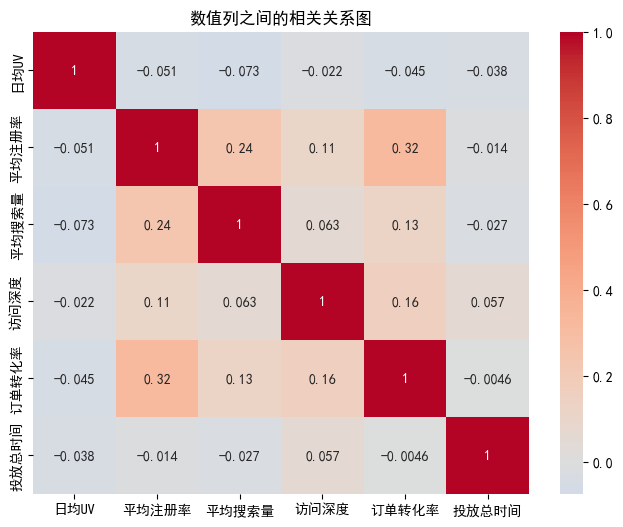

In [24]:
# 建模之前通常还需要检验变量之间的相关性，如果自变量之间具有强相关性，会影响模型的准确性，需要重点关注。
# 采用热力图可视化展示连续变量之间的相关性。
correlation_matrix = df.corr()
"""
correlation_matrix = df.corr(method='pearson',numeric_only=True)；pandas版本问题，原来corr函数自动忽略字符串等非浮点数的特性被修改。
现在需要加上numeric_only=True才会忽略字符串。
"""
# 绘制相关关系图
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('数值列之间的相关关系图')
plt.show
# 通过相关性结果分析可知，7 个特征中平均停留时间和访问深度的相关系数为 0.72，这两个指标具有较高的相关性；其他特征之间的相关性关系都不突出。

In [11]:
# 通过上面的步骤我们知道，平均停留时间和访问深度具有较高的相关性，本次用到的 K-Means 模块由于是基于距离的计算，
# 因此较高的相关性会在一定程度上导致距离计算的偏差，即数据之间的相似度会由于两个具有较高相关性的指标而“过度相似”。
# 再结合平均停留时间中有 2个缺失值，因此，这里将平均停留时间指标去除，保留访问深度。

# 删除平均平均停留时间列
df = df.drop(['平均停留时间'], axis=1)  

In [12]:
# 字符串本身即使转换为数值型索引也是没有"距离"意义的。
# 例如，对于素材类型，gif，可以用 1 和 2 表示 ，也可以用 2 和 4 表示，无论使用哪种方法，代表的只是不同素材类型的区别，而不是素材类型之间的距离是 1 或 2。 
# 因此，直接基于数值型索引并做距离计算并不符合实际逻辑。
# 而通过OneHotEncoder做转换之后的数据，能将原有的字符串索引变为标志变量，不会引入偏好或权重，而只是表示一个分类是否存在。
# 转换后的新特征是有实际解释意义且可以直接做距离计算。

# 分类属性做one-hot encode处理
cols = ['素材类型','广告类型','合作方式','广告尺寸','广告卖点']
model_ohe = OneHotEncoder(sparse=False)  # 建立OneHotEncode对象,设置了参数 sparse=False 的意义是转换后的矩阵为完整的编码数组，而不是压缩后的稀疏矩阵 。 
ohe_matrix = model_ohe.fit_transform(df[cols])  # 直接转换
print(ohe_matrix.shape,"\n",ohe_matrix)
# 数据集中这5列共有27种

(889, 27) 
 [[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]]


In [13]:
df.columns

Index(['渠道代号', '日均UV', '平均注册率', '平均搜索量', '访问深度', '订单转化率', '投放总时间', '素材类型',
       '广告类型', '合作方式', '广告尺寸', '广告卖点'],
      dtype='object')

In [14]:
# 日均UV有几万的量级，而转化率的范围却是 0～1，因此需要做数据标准化。这里使用的是 Min-Max标准化方法。
# 标准化的实施是针对数值型字段进行的，因此这里通过 data_iloc[:, 1:7] 选择需要标准化的数据。
# 下面使用 MinMaxScaler（）建立标准化模型对象，然后对模型对象应用fit_transform方法做标准化变换。最后输出标准化的结果，并保留两位小数。
sacle_matrix = df.iloc[:, 1:7]  # 获得要转换的矩阵
model_scaler = MinMaxScaler()  # 建立MinMaxScaler模型对象
data_scaled = model_scaler.fit_transform(sacle_matrix)  # MinMaxScaler标准化处理
print(data_scaled.round(2))

[[0.   0.18 0.02 0.01 0.12 0.66]
 [0.01 0.1  0.03 0.01 0.01 0.62]
 [0.   0.06 0.05 0.01 0.01 0.1 ]
 ...
 [0.01 0.01 0.   0.   0.   0.72]
 [0.05 0.   0.   0.   0.   0.31]
 [0.   0.   0.   0.53 0.   0.62]]


In [15]:
# 上面我们分别对连续变量和分类变量做了数据处理，这里需要将处理后的结果合并起来。使用 Numpy 的 hstack方法，将 data_scaled 、ohe_matrix合并，形成最终输入 X。 
# 注：这里的X不包含渠道的唯一标志列，因为该列在此聚类案例中没有实际建模意义。
X = np.hstack((data_scaled, ohe_matrix)) #默认横向拼接
X.shape

(889, 33)

In [16]:
# 通过平均轮廓系数检验得到最佳K-Means聚类模型
score_list = list()  # 用来存储每个K下模型的平局轮廓系数
silhouette_int = -1  # 初始化的平均轮廓系数阀值
for n_clusters in range(2, 5):  # 遍历从2、3、4个聚类群组数
    model_kmeans = KMeans(n_clusters=n_clusters)  # 建立聚类模型对象
    labels_tmp = model_kmeans.fit_predict(X)  # 训练聚类模型，得到样本的聚类标签
    silhouette_tmp = silhouette_score(X, labels_tmp)  # 得到每个K下的平均轮廓系数
    if silhouette_tmp > silhouette_int:  # 如果平均轮廓系数更高
        best_k = n_clusters  # 保存K将最好的K存储下来
        silhouette_int = silhouette_tmp  # 保存平均轮廓得分
        best_kmeans = model_kmeans  # 保存模型实例对象
        cluster_labels_k = labels_tmp  # 保存聚类标签
    score_list.append([n_clusters, silhouette_tmp])  # 将每次K及其得分追加到列表
print('{:*^60}'.format('K value and silhouette summary:'))
print(np.array(score_list))  # 打印输出所有K下的详细得分
print('Best K is:{0} with average silhouette of {1}'.format(best_k, silhouette_int))
# 上述结果显示了不同 K 下的平均轮廓得分。就经验看，如果平均轮廓得分值小于 0，意味着聚类效果不佳；
# 如果值大于 0 且小于 0.5， 那么说明聚类效果一般；如果值大于 0.5，则说明聚类效果比较好。
# 本实验在 K=4 时，得分为 0.5021，说明效果较好。

**************K value and silhouette summary:***************
[[2.         0.38655493]
 [3.         0.45757883]
 [4.         0.50209812]]
Best K is:4 with average silhouette of 0.5020981194788053


In [17]:
# 我们选定最佳K值建立好K-Means模型，下面我们要进行聚类结果的输出和分析。
# 原始数据和聚类标签整合
cluster_labels = pd.DataFrame(cluster_labels_k, columns=['clusters'])  # 获得训练集下的标签信息
merge_data = pd.concat((df, cluster_labels), axis=1)  # 将原始处理过的数据跟聚类标签整合
# 在合并数据集时，这里没有使用数据建模时的 X 与 cluster_labels合并，而是使用了经过缺失值填充后的 df数组做合井，目的是在分析时能够再现不同特征下原始值的特征。
# 如果使用 X 则其标准化的数值不符合业务的实际数据分布范围，会导致数据难以理解。
merge_data.head(5)

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点,clusters
0,A203,3.69,0.0071,0.0214,2.3071,0.0258,20,jpg,banner,roi,140*40,打折,3
1,A387,178.70,0.0040,0.0324,2.0489,0.0030,19,jpg,banner,cpc,140*40,满减,3
2,A388,91.77,0.0022,0.0530,1.8771,0.0026,4,jpg,banner,cpc,140*40,满减,3
3,A389,1.09,0.0074,0.3382,4.2426,0.0153,10,jpg,banner,cpc,140*40,满减,3
4,A390,3.37,0.0028,0.1740,2.1934,0.0007,30,jpg,banner,cpc,140*40,满减,3


In [18]:
# 计算每个聚类类别下的样本量和样本占比：
# 计算每个聚类类别的样本量
clustering_count = pd.DataFrame(merge_data['渠道代号'].groupby(merge_data['clusters']).count()).T.rename({'渠道代号': 'counts'})  
print("clustering_count:\n",clustering_count)
# 计算每个聚类类别的样本量占比
clustering_ratio = (clustering_count / len(merge_data)).round(2).rename({'counts': 'percentage'})  
print("clustering_ratio:\n",clustering_ratio)

clustering_count:
 clusters   0    1    2    3
counts    73  349  313  154
clustering_ratio:
 clusters       0     1     2     3
percentage  0.08  0.39  0.35  0.17


In [19]:
# 计算各个聚类类别内部最显著特征值：
cluster_features = []  # 空列表，用于存储最终合并后的所有特征信息
for line in range(best_k):  # 最佳聚类数best_k
    label_data = merge_data[merge_data['clusters'] == line]  # 获得特定类的数据
    part1_data = label_data.iloc[:, 1:7]  # 获得数值型数据特征
    part1_desc = part1_data.describe().round(3)  # 得到数值型特征的描述性统计信息
    merge_data1 = part1_desc.iloc[1, :]  # 新版本，得到数值型特征的均值
    
    part2_data = label_data.iloc[:, 7:-1]  # 获得字符串型数据特征
    part2_desc = part2_data.describe(include='all')  # 获得字符串型数据特征的描述性统计信息
    merge_data2 = part2_desc.iloc[2, :]  # 获得字符串型数据特征的最频繁值
    merge_line = pd.concat((merge_data1, merge_data2), axis=0)  # 将数值型和字符串型典型特征沿行合并
    cluster_features.append(merge_line)  # 将每个类别下的数据特征追加到列表

In [20]:
cluster_pd = pd.DataFrame(cluster_features).T  # 将列表转化为矩阵
print('{:*^60}'.format('Detailed features for all clusters:'))#:*^60 是格式化说明符，其中 * 是填充字符，^ 是对齐方式（居中），60 是字段的宽度。
all_cluster_set = pd.concat((clustering_count, clustering_ratio, cluster_pd),axis=0)  # 将每个聚类类别的所有信息合并
print(all_cluster_set)

************Detailed features for all clusters:*************
                   0        1        2        3
counts            73      349      313      154
percentage      0.08     0.39     0.35     0.17
日均UV        1401.525  300.205  572.521  613.836
平均注册率          0.001    0.001    0.001    0.003
平均搜索量          0.033    0.016    0.051     0.02
访问深度           1.727     2.27    2.145     2.19
订单转化率          0.002    0.002    0.004    0.003
投放总时间         15.603    15.35   17.125   15.682
素材类型             swf      jpg      swf      jpg
广告类型            tips       横幅      不确定   banner
合作方式             cpm      cpc      roi      cpc
广告尺寸         450*300   600*90   600*90  308*388
广告卖点              打折       直降       打折       满减


In [21]:
num_sets = cluster_pd.iloc[:6, :].T.astype(np.float64)  # 获取要展示的数据(数值类型)
num_sets_max_min = model_scaler.fit_transform(num_sets)  # 获得标准化后的数据
num_sets_max_min

array([[1.        , 0.        , 0.48571429, 0.        , 0.        ,
        0.14253521],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.24726328, 0.        , 1.        , 0.76979742, 1.        ,
        1.        ],
       [0.28477736, 1.        , 0.11428571, 0.85267035, 0.5       ,
        0.18704225]])

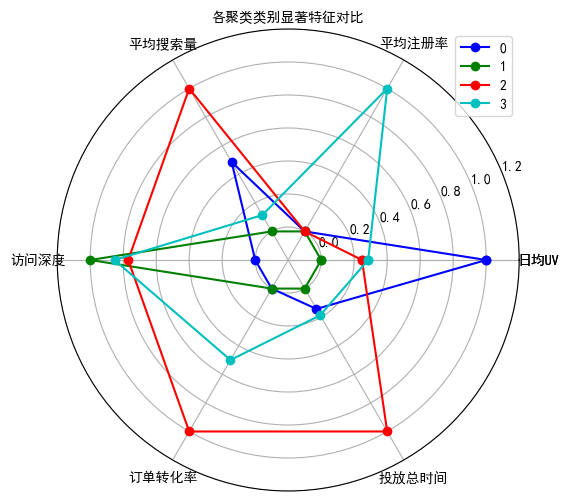

In [22]:
# part2 画布基本设置
fig = plt.figure(figsize=(6,6))  # 建立画布
ax = fig.add_subplot(111, polar=True)  # 增加子网格，注意polar参数
labels = np.array(merge_data1.index)  # 设置要展示的数据标签
cor_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']  # 定义不同类别的颜色
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)  # 计算各个区间的角度
angles = np.concatenate((angles, [angles[0]]))  # 建立相同首尾字段以便于闭合
labels = np.concatenate((labels,[labels[0]]))   # 新版本增加，对labels进行封闭
# part3 画雷达图
for i in range(len(num_sets)):  # 循环每个类别
    data_tmp = num_sets_max_min[i, :]  # 获得对应类数据
    data = np.concatenate((data_tmp, [data_tmp[0]]))  # 建立相同首尾字段以便于闭合
    ax.plot(angles, data, 'o-', c=cor_list[i], label=i)  # 画线
# part4 设置图像显示格式
ax.set_thetagrids(angles * 180 / np.pi, labels, fontproperties="SimHei")  # 设置极坐标轴
ax.set_title("各聚类类别显著特征对比", fontproperties="SimHei")  # 设置标题放置
ax.set_rlim(-0.2, 1.2)  # 设置坐标轴尺度范围
plt.legend(loc=0)  # 设置图例位置